<a href="https://colab.research.google.com/github/hevertonvalerio/Challenge/blob/main/challenge_modelo_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install pytorch_lightning
!pip install darts

In [29]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import TQDMProgressBar

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset

import warnings

warnings.filterwarnings("ignore")

import logging

logging.disable(logging.CRITICAL)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [30]:
import yfinance as yf
from datetime import date, timedelta

today = date.today()
one_year_ago = today - timedelta(days=(365*3))

btc = yf.download("AVIR", start=one_year_ago, end=today)
print(btc.info())
btc

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2021-10-27 00:00:00+00:00 to 2024-10-25 00:00:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AVIR)  754 non-null    float64
 1   (Close, AVIR)      754 non-null    float64
 2   (High, AVIR)       754 non-null    float64
 3   (Low, AVIR)        754 non-null    float64
 4   (Open, AVIR)       754 non-null    float64
 5   (Volume, AVIR)     754 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.2 KB
None


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AVIR,AVIR,AVIR,AVIR,AVIR,AVIR
Date,,,,,,
2021-10-27 00:00:00+00:00,12.17,12.17,12.510,11.910,12.37,2265000
2021-10-28 00:00:00+00:00,11.96,11.96,12.390,11.860,12.23,2774600
2021-10-29 00:00:00+00:00,11.64,11.64,12.055,11.580,11.96,1583300
2021-11-01 00:00:00+00:00,12.00,12.00,12.130,11.500,11.60,1962500
2021-11-02 00:00:00+00:00,11.72,11.72,12.135,11.300,12.09,1848000
...,...,...,...,...,...,...
2024-10-21 00:00:00+00:00,3.59,3.59,3.860,3.585,3.82,180500
2024-10-22 00:00:00+00:00,3.56,3.56,3.595,3.510,3.56,52200


In [31]:
btc_tidy = btc[["Close"]].reset_index()
btc_tidy = btc_tidy.rename(columns={'Date': 'Date', 'Close': 'Close'})
btc_tidy

Price,Date,Close
Ticker,,AVIR
0,2021-10-27 00:00:00+00:00,12.17
1,2021-10-28 00:00:00+00:00,11.96
2,2021-10-29 00:00:00+00:00,11.64
3,2021-11-01 00:00:00+00:00,12.00
4,2021-11-02 00:00:00+00:00,11.72
...,...,...
749,2024-10-21 00:00:00+00:00,3.59
750,2024-10-22 00:00:00+00:00,3.56
751,2024-10-23 00:00:00+00:00,3.48


In [32]:
btc_tidy['Date'] = pd.to_datetime(btc_tidy['Date']).dt.tz_localize(None)


In [33]:
btc_tidy

Price,Date,Close
Ticker,,AVIR
0,2021-10-27,12.17
1,2021-10-28,11.96
2,2021-10-29,11.64
3,2021-11-01,12.00
4,2021-11-02,11.72
...,...,...
749,2024-10-21,3.59
750,2024-10-22,3.56
751,2024-10-23,3.48


In [41]:
# prompt: conte quantos nulos tem em btc_tidy

btc_tidy.isnull().sum()

,,0
Price,Ticker,
Date,,0
Close,AVIR,0


In [36]:
btc_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   (Date, )       754 non-null    datetime64[ns]
 1   (Close, AVIR)  754 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.9 KB


In [45]:
ts = TimeSeries.from_dataframe(btc_tidy, 'Date', 'Close', fill_missing_dates=True, freq='D')

In [38]:
try:
  # Attempt to infer frequency automatically
  ts = TimeSeries.from_dataframe(btc_tidy, 'Date', 'Close', fill_missing_dates=True)
except ValueError:
  # If inference fails, specify frequency manually
  # Replace 'D' with your actual frequency (e.g., 'B' for business days, 'W' for weekly, etc.)
  ts = TimeSeries.from_dataframe(btc_tidy, 'Date', 'Close', fill_missing_dates=True, freq='D')

In [46]:
ts

<TimeSeries (DataArray) (Date: 1095, component: 1, sample: 1)> Size: 9kB
array([[[12.17000008]],

       [[11.96000004]],

       [[11.64000034]],

       ...,

       [[ 3.48000002]],

       [[ 3.38000011]],

       [[ 3.3499999 ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 9kB 2021-10-27 2021-10-28 ... 2024-10-25
  * component  (component) <U17 68B "('Close', 'AVIR')"
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [40]:
ts.isnull()

AttributeError: 'TimeSeries' object has no attribute 'isnull'

adaptando paper

In [47]:
# Read data:
# ts = btc_tidy_array

# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp("20240601"))

scaler = Scaler()

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
ts_scaled = scaler.transform(ts)

# We'll use the month as a covariate (scaling not required as one-hot-encoded)
month_series = datetime_attribute_timeseries(ts, attribute="month", one_hot=True)

In [48]:
model_name = "TCN_air"
model_air = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12,
    n_epochs=250,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
    save_checkpoints=True,
    model_name=model_name,
    force_reset=True,
    **generate_torch_kwargs()
)

In [49]:
model_air.fit(
    series=train_scaled,
    past_covariates=month_series,
    val_series=val_scaled,
    val_past_covariates=month_series,
)

Training: 0it [00:00, ?it/s]

TCNModel(output_chunk_shift=0, kernel_size=5, num_filters=3, num_layers=None, dilation_base=2, weight_norm=True, dropout=0.1, input_chunk_length=13, output_chunk_length=12, n_epochs=250, random_state=0, save_checkpoints=True, model_name=TCN_air, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7a7ba01e7f40>]})

In [50]:
model_air = TCNModel.load_from_checkpoint(model_name=model_name, best=True)

In [51]:
backtest = model_air.historical_forecasts(
    series=ts_scaled,
    past_covariates=month_series,
    start=val_scaled.start_time(),
    forecast_horizon=6,
    retrain=False,
    verbose=True,
)

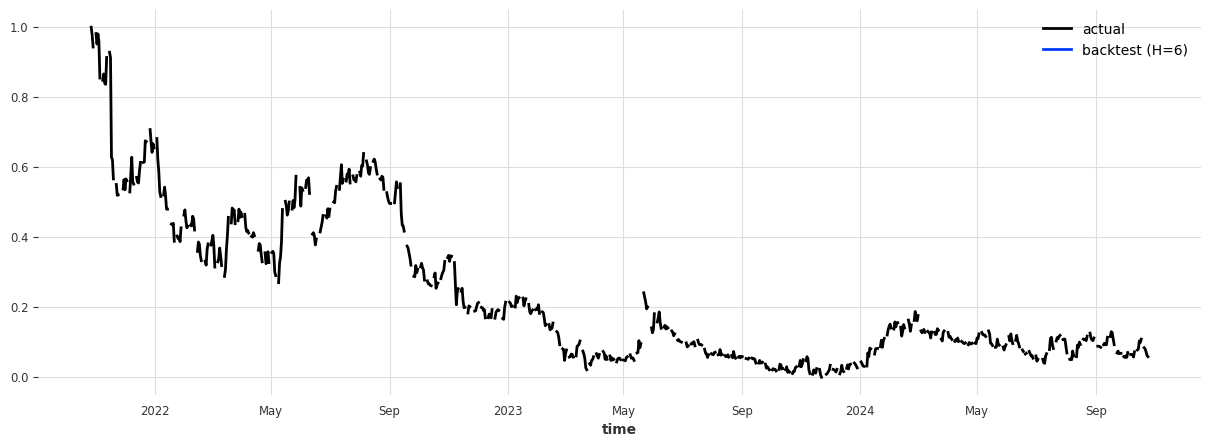

In [52]:
plt.figure(figsize=(15, 5))
ts_scaled.plot(label="actual")
backtest.plot(label="backtest (H=6)")

plt.legend()
plt.show()

<Axes: >

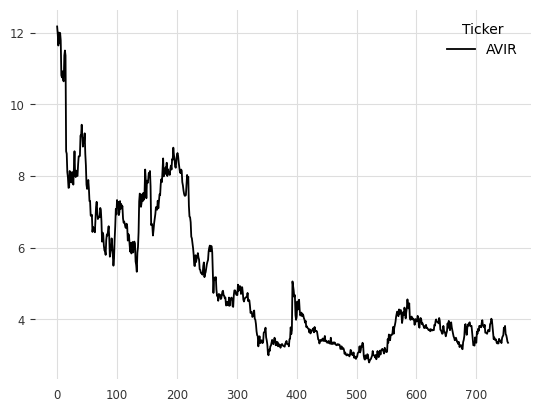

In [53]:
btc_tidy['Close'].plot(label="actual")